In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.conv_learner import *
PATH = os.path.expanduser('~/data/planet/')

In [2]:
!ls {PATH}

models			  test-jpg-additional	    train-jpg
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv
test-jpg		  tmp


In [3]:
from planet import f2

metrics=[f2] # imposed by https://www.kaggle.com/c/planet-understanding-the-amazon-from-space
f_model = resnet34

label_csv = os.path.join(PATH, 'train_v2.csv')
with open(label_csv) as f:
    n = len(f.readlines()) - 1
val_idxs = get_cv_idxs(n)

In [4]:
def get_data(sz, f_model):
    tfms = tfms_from_model(
        f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(
        PATH,
        os.path.join(PATH, 'train-jpg'),
        label_csv,
        tfms=tfms,
        suffix=".jpg",
        val_idxs=val_idxs,
        test_name=os.path.join(PATH, "test-jpg"))

In [5]:
data = get_data(256, f_model) # for initial look, pick smaller size later

In [6]:
x, y = next(iter(data.val_dl))

In [7]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [8]:
list(c for (c, v) in zip(data.classes, y[0]) if v)

['agriculture', 'clear', 'primary', 'water']

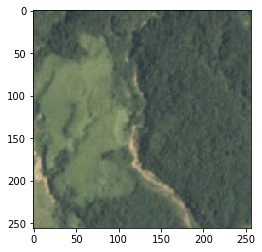

In [9]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.3);

In [10]:
sz = 64
data = get_data(sz, f_model)

The training/test time augmentation happens on the full images with resizing to `sz` by `sz` pixels as the last step (see a bit before 1:40:59).  Depending on the original image size, this can be slow.  `data.resize` does one pass over the data, generating resized images so that they load and transform faster.  The result is cached.  This step is not mandatory, but speeds up the process.

In [11]:
data = data.resize(round(sz * 1.3), 'tmp')

In [12]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.228767   0.366668   0.792205  



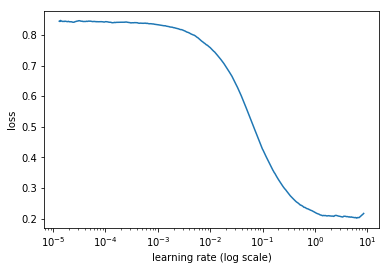

In [13]:
learn.sched.plot()

A first `learn.fit(0.2, 3, cycle_len=1)` didn't do a lot, so I reloaded and 
increased the training effort:

In [14]:
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.1454     0.132975   0.883676  
    1      0.139883   0.126371   0.889546                    
    2      0.133468   0.124889   0.891491                    
    3      0.133256   0.124523   0.89329                     
    4      0.131414   0.122379   0.892685                    
    5      0.131706   0.121438   0.893703                    
    6      0.123664   0.120497   0.895037                    



[array([0.1205]), 0.8950368751319154]

In [15]:
learn.unfreeze()
learn.fit([0.2/9, 0.2/3, 0.2], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.115642   0.105603   0.911392  
    1      0.110199   0.104956   0.909575                    
    2      0.101926   0.098523   0.916946                     
    3      0.108046   0.103368   0.914168                    
    4      0.098153   0.09729    0.917784                     
    5      0.091428   0.095505   0.920221                     
    6      0.088054   0.096307   0.919897                     



[array([0.09631]), 0.9198974425869346]

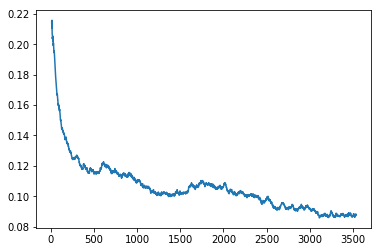

In [16]:
learn.sched.plot_loss()

In [17]:
learn.save("sz64")

epoch      trn_loss   val_loss   f2                           
    0      0.131492   0.173235   0.886006  



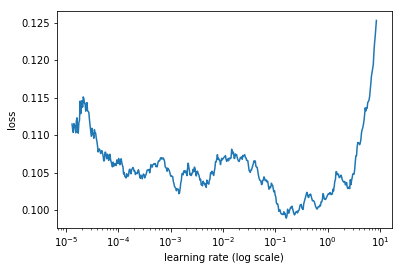

In [18]:
sz = 128
data = get_data(sz, f_model)
learn.set_data(data) # this also re-freezes the model
learn.freeze() # just to be sure, because the `official' notebook does it
learn.lr_find()
learn.sched.plot()

It doesn't look like I can do much better, training again out of curiosity.

In [19]:
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.098035   0.096778   0.916713  
    1      0.095852   0.095031   0.919918                     
    2      0.094925   0.094525   0.919941                     
    3      0.093367   0.094329   0.919191                     
    4      0.093746   0.094012   0.92062                      
    5      0.092671   0.093332   0.921111                     
    6      0.091493   0.093202   0.921429                     



[array([0.0932]), 0.9214287809870251]

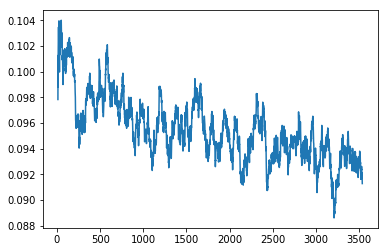

In [20]:
learn.sched.plot_loss()

In [21]:
learn.save("sz128")

Indeed, it didn't really improve compared to the previous optimization run: we go from `[array([0.09631]), 0.9198974425869346]` to `[array([0.0932]), 0.9214287809870251]`.  Still, at least it looks like I am overfitting a bit less.

In [22]:
learn.unfreeze()
learn.fit([0.2/9, 0.2/3, 0.2], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.091754   0.088131   0.925236  
    1      0.090766   0.088478   0.924822                     
    2      0.084566   0.086545   0.92776                      
    3      0.093854   0.090016   0.925176                     
    4      0.082305   0.0888     0.925959                     
    5      0.07595    0.087655   0.926762                     
    6      0.073892   0.087208   0.927613                     



[array([0.08721]), 0.9276134755599053]

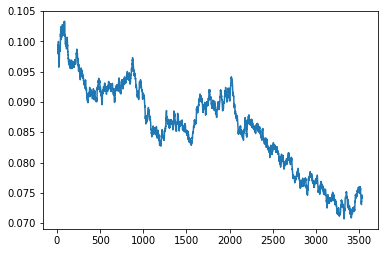

In [24]:
learn.sched.plot_loss()

It's a bit better than before but not by much. OTOH, it looks like overfitting.

epoch      trn_loss   val_loss   f2                           
    0      0.115366   0.160489   0.891652  



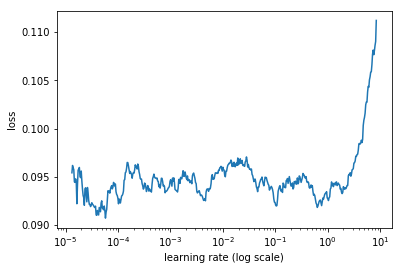

In [25]:
sz = 256
data = get_data(sz, f_model)
learn.set_data(data) # this also re-freezes the model
learn.freeze() # just to be sure, because the `official' notebook does it
learn.lr_find()
learn.sched.plot()

Again, not much to hope here... trying anyway.

In [26]:
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.090763   0.090948   0.92313   
    1      0.087791   0.090108   0.92442                      
    2      0.086878   0.089658   0.9244                       
    3      0.089271   0.08997    0.922913                     
    4      0.088936   0.089286   0.924182                     
    5      0.087716   0.088591   0.925565                     
    6      0.085415   0.08817    0.926524                     



[array([0.08817]), 0.926524173115476]

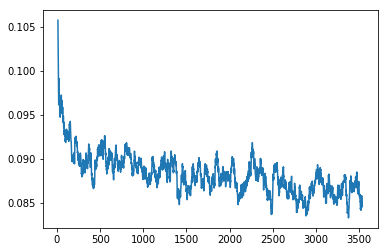

In [27]:
learn.sched.plot_loss()

In [28]:
learn.unfreeze()
learn.fit([0.2/9, 0.2/3, 0.2], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.086382   0.084204   0.930689  
    1      0.087599   0.084038   0.931743                     
    2      0.078341   0.082496   0.932121                     
    3      0.083276   0.086176   0.929724                     
    4      0.07864    0.085093   0.929279                     
    5      0.070487   0.084875   0.929449                     
    6      0.06777    0.084732   0.930944                     



[array([0.08473]), 0.9309444455659495]

In [29]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [30]:
f2(preds,y)

0.9288880138800718

Strange: using TTA doesn't improve my score (even though it helped in the 'official' notebook) + I seem to have overfit but the 'official' notebook doesn't seem to have the same problem.

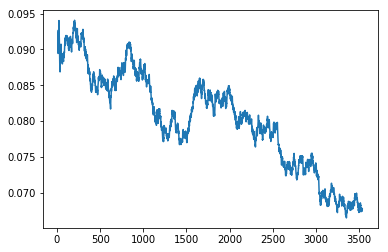

In [31]:
learn.sched.plot_loss()